<a href="https://githubtocolab.com/alsinmr/CaCO3_archive/blob/main/NOEcalcs.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" ></a>

# NOE calculations
We will calculate the expected correlation time for the observed enhancement (0.6). Note that the number of involved protons affects the outcome.

In [2]:
import sys
if "google.colab" in sys.modules:
    !git clone https://github.com/alsinmr/pyDR
    !git clone https://github.com/alsinmr/CaCO3_archive
    import pyDR
    %cd CaCO3_archive/
else:
    sys.path.append('/Users/albertsmith/Documents/GitHub/')
    import pyDR
import numpy as np
import matplotlib.pyplot as plt

from NMRparameters import posC,posH0,box

In [3]:
def dist(pos0,pos):
    """
    Finds the box-corrected distances between atom with position "pos0" and
    atoms with position "pos"
    """
    Dpos=pos0-pos
    i=Dpos>box/2
    ib=np.argwhere(i).T[1]
    Dpos[i]=Dpos[i]-box[ib]

    i=Dpos<-box/2
    ib=np.argwhere(i).T[1]
    Dpos[i]=Dpos[i]+box[ib]
    return np.sqrt((Dpos**2).sum(1))

def find_pairs():
    """
    Pairs up the 1H according to which are on the same water
    """
    pos=posH0
    unused=np.ones(len(pos),dtype=bool)
    index0=[]
    index1=[]
    for _ in range(len(pos)//2):
        i0=np.argmax(unused)
        d=dist(pos[i0],pos)
        i1=np.argmin(np.abs(d-1.577))  #Search for H on same water
        index0.append(i0)
        index1.append(i1)
        unused[i0]=False
        unused[i1]=False
    return np.array(index0),np.array(index1)

def Aeff():
    index0,index1=find_pairs()
    A0=pyDR.tools.dipole_coupling(dist(posC,posH0[index0])/10,'1H','13C')
    A1=pyDR.tools.dipole_coupling(dist(posC,posH0[index1])/10,'1H','13C')
    
    return np.sort(((A0+A1)/2).repeat(2))[::-1]

def T1_NOE(nH=18):
    Ae=Aeff()
    R1=[]
    NOE=[]
    for Ae in Aeff()[:nH]:
        nmr=pyDR.Sens.NMR(z=np.linspace(-11,-7.5,200),Type=['R1','NOE'],v0=400,Nuc='13C',Nuc1='1H',dXY=Ae)
        R1.append(nmr.rhoz[0])
        NOE.append(nmr.rhoz[1])
        
    return nmr.z,np.array(R1).sum(0),np.array(NOE).sum(0)

def eNOE(nH=18):
    z,R1,NOE=T1_NOE(nH)
    return z,pyDR.tools.NucInfo('1H')/pyDR.tools.NucInfo('13C')*NOE/R1

In the following, we calculate the total H–C NOE transfer rate from all 18 $^1$H in the unit cell from the mhc.magres file, as well as the $^{13}$C $R_1$ relaxation rate constant. From the ratio of these rates, we can calculate the NOE enhancement ($\eta$) as a function of correlation time. Note that the NOE enhancement does not depend on the size of the H–C dipole couplings or the number of $^1$H that are included in the calculation (this may be verified by entering an integer between 1 and 18 into the eNOE function, which changes the number of $^1$H included). On the other hand, the $^{13}$C $T_1$ will depend on how many $^1$H are included, although 75% of the $^{13}$C $R_1$ rate comes from the closest two water molecules.

In the plot, we indicate the hopping rate yielding an enhancement of 0.6. Note that the $T_1$ at this correlation time is already much too short compared to the experimental values (222 or 132 s, depending on $^{13}$C concentration), indicating that the source of the NOE must be motion with smaller amplitude than water hopping.

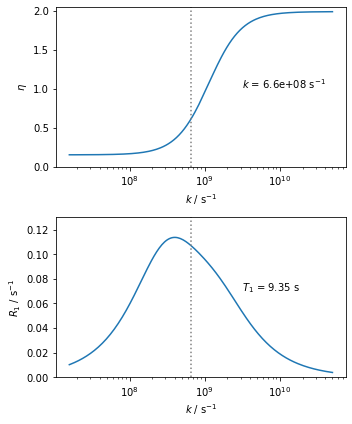

In [4]:
fig,ax=plt.subplots(2,1)

z,e=eNOE()
z,R1,NOE=T1_NOE()
ax[0].semilogx((10**-z)/2,e)
ax[0].set_ylim([0,2.05])
ax[0].set_xlabel(r'$k$ / s$^{-1}$')
ax[0].set_ylabel(r'$\eta$')

ax[1].semilogx((10**-z)/2,R1)
ax[1].set_xlabel(r'$k$ / s$^{-1}$')
ax[1].set_ylabel(r'$R_1$ / s$^{-1}$')
ax[1].set_ylim([0,.13])


i=np.argmin(np.abs(e-0.6))
ax[0].semilogx(0.5*10**-np.array([z[i],z[i]]),ax[0].get_ylim(),color='grey',linestyle=':')
ax[0].text(10**9.5,1,rf'$k$ = {0.5*10**-z[i]:.1e} s$^{{-1}}$')
ax[1].semilogx(0.5*10**-np.array([z[i],z[i]]),ax[1].get_ylim(),color='grey',linestyle=':')
ax[1].text(10**9.5,.07,rf'$T_1$ = {1/R1[i]:.2f} s')


fig.set_size_inches([5,6])
fig.tight_layout()